In [1]:
import mido
import glob
import matplotlib.pyplot as plt
import numpy as np
import os

## select files

In [2]:
#all_files = glob.glob(r'd:\Program Files\samples\Midi\0-9Other\CLASSIC\*.mid', recursive=True)
all_files = glob.glob(r'd:\Program Files\samples\Midi\**\*.mid', recursive=True)

In [3]:
# selected range of max time delays and bpm
tempos = []
timesteps = []
sel_files = []

n_under_thres = 0
thres_dt = 256
for f in all_files:
    try:
        mid = mido.MidiFile(f)
    except:
        pass
    tpb = mid.ticks_per_beat
    
    if not (70 <= tpb <= 120):
        continue
    
    under = True
    for i, track in enumerate(mid.tracks):
        for msg in track:
            if msg.type in ['note_on', 'note_off']:
                timesteps.append(msg.time)
                if msg.time>=thres_dt:
                    under = False
    if under:
        n_under_thres += 1
        sel_files.append(f)
                
    
    tempos.append(tpb)

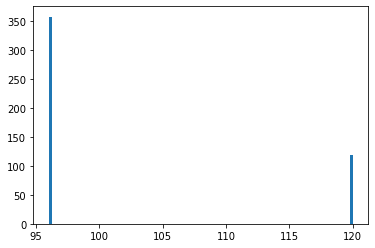

In [4]:
plt.hist(tempos, 100);

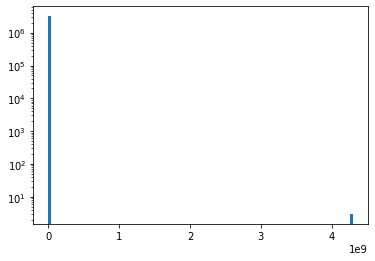

In [5]:
plt.hist(timesteps, 100, log=1);

In [6]:
print(f'selected files fraction: {n_under_thres/len(all_files)*100:.1f}%')

selected files fraction: 14.9%


In [7]:
# analyse selected:
tempos = []
timesteps = []

n_under_thres = 0
thres_dt = 256
for f in sel_files:
    try:
        mid = mido.MidiFile(f)
    except:
        pass
    tpb = mid.ticks_per_beat
    
    if not (70 <= tpb <= 120):
        continue
    
    under = True
    for i, track in enumerate(mid.tracks):
        for msg in track:
            if msg.type in ['note_on', 'note_off']:
                timesteps.append(msg.time)
                if msg.time>=thres_dt:
                    under = False
    if under:
        n_under_thres += 1
                
    
    tempos.append(tpb)

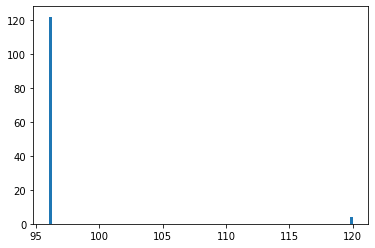

In [8]:
plt.hist(tempos, 100);

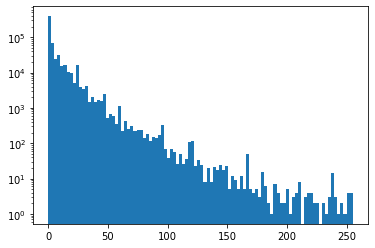

In [9]:
plt.hist(timesteps, 100, log=1);

In [10]:
print(f'number of selected files = {n_under_thres}')

number of selected files = 126


## generate seq data for training

Simpest approach - all midi notes treated as is, i.e. we have On and Off signals

In [11]:
def midi_to_seq(mid):
    bufs = []
    idx_map={'note_on':1, 'note_off':0}
    for i, track in enumerate(mid.tracks):
        for msg in track:
            if msg.type in ['note_on', 'note_off']:
                buf = np.zeros(132) # on/off, 128 notes, velocity normd value & time normed value 
                
                buf[idx_map[msg.type]] = 1.
                buf[msg.note+2] = 1.
                buf[130] = msg.velocity/128
                buf[131] = msg.time/256
                
                bufs.append(buf)
    return np.array(bufs)

In [13]:
# save image of a melody for visual inspection
f = sel_files[0]
mid = mido.MidiFile(f)
b = midi_to_seq(mid)

plt.imsave('b.png', b)

In [164]:
for i, f in enumerate(sel_files):
    try:
        mid = mido.MidiFile(f)
    except:
        pass
        
    b = midi_to_seq(mid)
    np.save(f'midi_data\{i:03d}.npy', b)

## read in samples generated by trained model and export midi

In [2]:
def SaveSeqMidi(seq, filename):
    types = ['note_off', 'note_on']
    midg = mido.MidiFile()
    midg.ticks_per_beat = 70
    track = mido.MidiTrack()
    midg.tracks.append(track)

    for m in seq:
        tp_1h = m[:2]
        note_1h = m[2:130]
        vel_f = m[130]
        time_f = m[131]
        
        tp_idx = np.argmax(tp_1h)
        tp = types[tp_idx]
        
        note = np.argmax(note_1h)
        
        vel = int(vel_f * 128)
        
        time = int(time_f * 256)
        msg = mido.Message(tp, note=note, velocity=vel, time=time)

        track.append(msg)

    midg.save(filename)

In [3]:
gen_samples = np.load('6_samples.npy')
print(gen_samples.shape)

(6, 4608, 132)


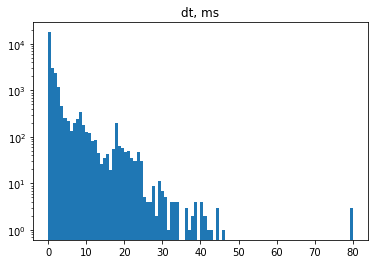

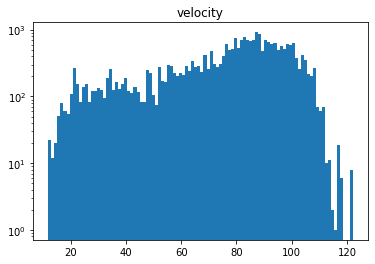

In [17]:
# inspection of data
plt.hist(gen_samples[..., -1].flatten()*256, 100, log=1);
plt.title('dt, ms')
plt.show()

plt.hist(gen_samples[..., -2].flatten()*128, 100, log=1);
plt.title('velocity')
plt.show()

In [4]:
# convert to midi
n_inp = 512
for i, gs in enumerate(gen_samples):
    SaveSeqMidi(gs, f'{i}_gen_all.mid')
    SaveSeqMidi(gs[:n_inp], f'{i}_gen_src.mid')
    SaveSeqMidi(gs[n_inp:], f'{i}_gen_tgt.mid')
    